In [168]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm

from tqdm import tqdm

In [169]:
import wget
import os

fname = "IBTrACS.ALL.v04r00.nc"
output_directory = "../data/external"
url = f"https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/{fname}"
if not os.path.exists(f"{output_directory}/{fname}"):
    wget.download(url, out = output_directory)


In [170]:
ds = xr.open_dataset(f"{output_directory}/{fname}")
ds = ds.assign(usa_status = ds.usa_status.astype("str"))
ds

<xarray.Dataset>
Dimensions:           (storm: 13803, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    history:                    Tue Mar 12 04:25:52 2024: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 4.8.1 (Homepage = ht...

(array([1.626560e+05, 4.252869e+06, 0.000000e+00, 5.036160e+05,
        0.000000e+00, 2.976600e+04, 3.022000e+03, 0.000000e+00,
        7.293000e+03, 9.858000e+03]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

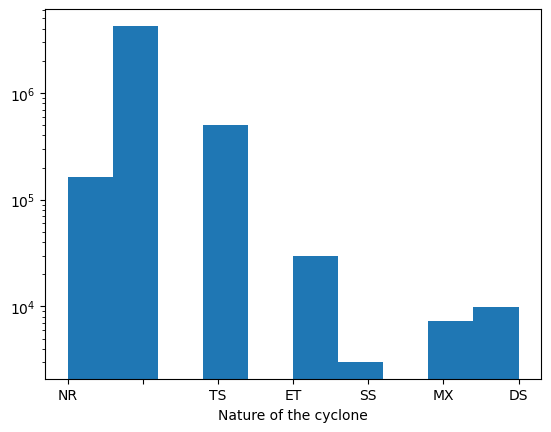

In [171]:
ds.nature.plot.hist(yscale = "log")

In [172]:
# check all wind variables available
wind = [var for var in list(ds) if "wind" in var]
# get indices for all storms that had at least one time with more than 64 knots
ds = ds.assign(wind = xr.concat([ds[var] for var in wind], "wind_source").mean("wind_source"))
ind = (ds.wind > 64).any("date_time")
# keep only the hurricanes
ds = ds.isel(storm = ind.values.nonzero()[0])
# naming Catarina
ind = ((ds.lon > -80) & (ds.lon<0) & (ds.lat < 0) & (ds.season == 2004)).any("date_time").values.nonzero()[0]
ds.name[ind] = "CATARINA"

In [173]:
category = ds.wind.copy()
category = category.where(~((ds.wind <= 33)), -1)
category = category.where(~((ds.wind > 33) & (ds.wind <= 63)), 0)
category = category.where(~((ds.wind > 63) & (ds.wind <= 82)), 1)
category = category.where(~((ds.wind > 82) & (ds.wind <= 95)), 2)
category = category.where(~((ds.wind > 95) & (ds.wind <= 112)), 3)
category = category.where(~((ds.wind > 112) & (ds.wind <= 136)), 4)
category = category.where(~((ds.wind > 136)), 5)
category.name = "category"
ds = ds.assign(category = category)

In [174]:
selected = [("Katrina", 2005), ("Catarina", 2004), ("Biparjoy", 2023), ("Seroja", 2021), ("Mawar", 2023)]
ind = []
for name, year in selected:
    ind.append(((ds.name.astype("str") == name.upper()) & (ds.season == year)).values.nonzero()[0])
ind = np.hstack(ind)
ds_selected = ds.isel(storm = ind).load()

In [176]:
ds = ds.isel(storm = (ds.nature.astype("str") == "TS").any("date_time").values.nonzero()[0])
ds = ds.isel(storm = (ds.season >= 1970).values.nonzero()[0])

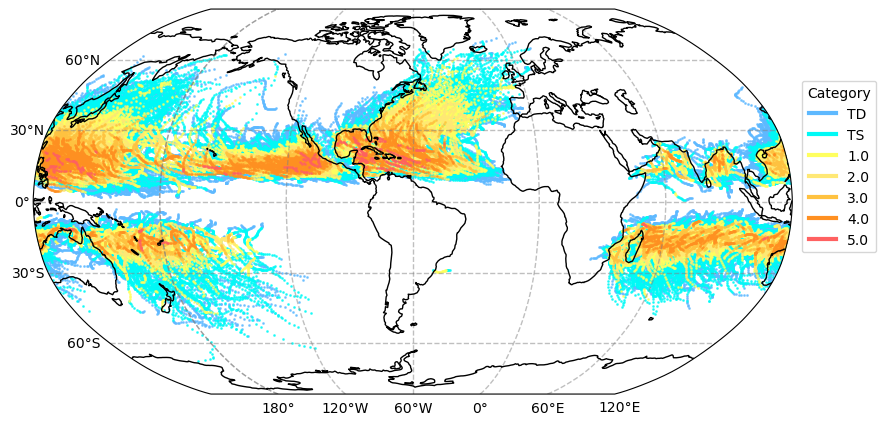

In [177]:
colors = ["#5eb9ffff","#00faf6ff","#ffff5fff","#ffe875ff","#ffc240ff","#ff9021ff","#ff6161ff"]
groups = ds[["time", "lon", "lat", "category"]].stack(obs = ["storm", "date_time"]).groupby("category")

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = -60))
ax.coastlines(zorder = 1e5)

for color, (cat, group) in zip(colors, groups):
    ax.scatter(group.lon.values, group.lat.values, s = 1, c = color, lw = 1, alpha = 0.7, transform = ccrs.PlateCarree());
    cat = "TD" if cat == -1 else cat
    cat = "TS" if cat == 0 else cat
    ax.plot([], [], c = color, lw = 3, label = cat)

ax.legend(loc = 4, bbox_to_anchor=(1.12, 0.35), title = "Category")
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

fig.savefig("../img/tracks_scatter.png", dpi = 300, bbox_inches = "tight")

In [178]:
# colors = ["#5eb9ffff","#00faf6ff","#ffe875ff","#ff9021ff","#ff6161ff"]
# groups = ds.groupby(ds.category.max("date_time"))

# fig = plt.figure(figsize=(10, 5))
# ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = -60))
# ax.coastlines(zorder = 1e5)

# for season, group_year in groups_year:
#     groups = group_year.groupby(group_year.category.max("date_time"))
#     for color, (cat, group) in zip(colors, groups):
#         ax.plot(group.lon.values.T, group.lat.values.T, c = color, lw = 1, alpha = 0.7, transform = ccrs.PlateCarree());
#         ax.plot([], [], c = color, lw = 3, label = int(cat))

# ax.legend(loc = 4, bbox_to_anchor=(1.12, 0.35), title = "Category")
# ax.set_global()
# fig.savefig("../img/tracks.png", dpi = 300, bbox_inches = "tight")

In [179]:
initial_longitude = ds.lon.isel(date_time = 0)
initial_latitude = ds.lat.isel(date_time = 0)
final_longitude = ds.lon.ffill("date_time").isel(date_time = -1)
final_latitude = ds.lat.ffill("date_time").isel(date_time = -1)

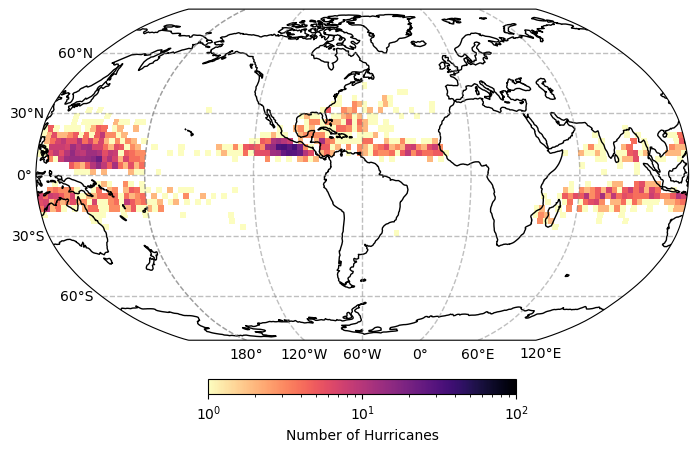

In [235]:
d = 3
bins = [np.arange(-180, 180 + d, d), np.arange(-90, 90 + d,d)]
H, lon, lat = np.histogram2d(initial_longitude, initial_latitude, bins = bins)
lon, lat = 0.5 * (lon[:-1] + lon[1:]), 0.5 * (lat[:-1] + lat[1:])
H = H.T
H[H == 0] = np.nan

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = -60))
# ax.stock_img()
ax.coastlines()

# ax.scatter(initial_longitude, initial_latitude, s = 10, transform = ccrs.PlateCarree(), c = "red", alpha = 0.4)
C = ax.pcolormesh(lon, lat, H, transform = ccrs.PlateCarree(), cmap = "magma_r", norm = LogNorm(vmin = 1, vmax = 100))
fig.colorbar(C, ax = ax, pad = 0.1, fraction = 0.04, label = "Number of Hurricanes", orientation = "horizontal")
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

fig.savefig("../img/origin_hurricanes.png", dpi = 300, bbox_inches = "tight")

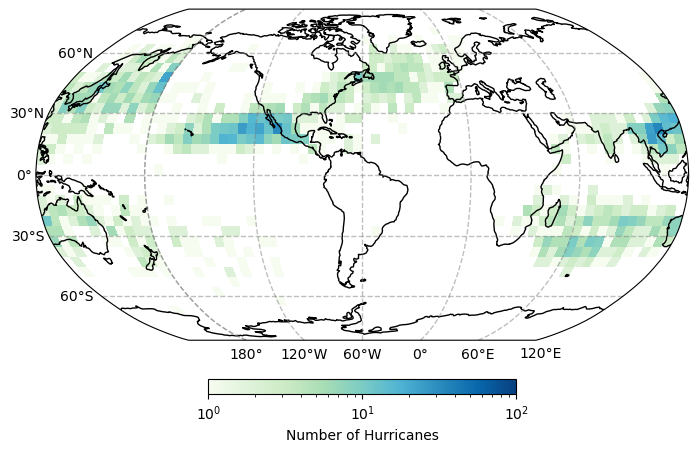

In [181]:
d = 5
bins = [np.arange(-180, 180 + d, d), np.arange(-90, 90 + d,d)]
H, lon, lat = np.histogram2d(final_longitude, final_latitude, bins = bins)
lon, lat = 0.5 * (lon[:-1] + lon[1:]), 0.5 * (lat[:-1] + lat[1:])
H = H.T
H[H == 0] = np.nan

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = -60))
# ax.stock_img()
ax.coastlines()

# ax.scatter(initial_longitude, initial_latitude, s = 10, transform = ccrs.PlateCarree(), c = "red", alpha = 0.4)
C = ax.pcolormesh(lon, lat, H, transform = ccrs.PlateCarree(), cmap = "GnBu", norm = LogNorm(vmin = 1, vmax = 100))
fig.colorbar(C, ax = ax, pad = 0.1, fraction = 0.04, label = "Number of Hurricanes", orientation = "horizontal")
ax.set_global()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

fig.savefig("../img/death_hurricanes.png", dpi = 300, bbox_inches = "tight")

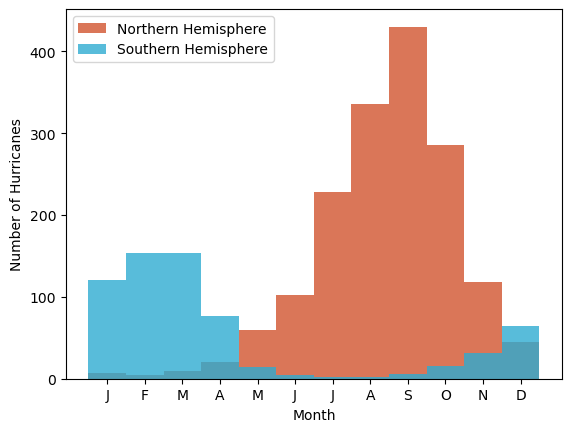

In [182]:
northern_hemisphere = (ds.lat.isel(date_time = 0) > 0).values.nonzero()[0]
southern_hemisphere = (ds.lat.isel(date_time = 0) < 0).values.nonzero()[0]

bins = np.arange(0.5, 12.5 + 1)
months = "J F M A M J J A S O N D".split()

dsi = ds.time.dt.month.mean("date_time")

colors = ["#d1542e", "#2eabd1"]
fig, ax = plt.subplots()
dsi.isel(storm = northern_hemisphere).plot.hist(bins = bins, alpha = 0.8, color = colors[0], label = "Northern Hemisphere")
dsi.isel(storm = southern_hemisphere).plot.hist(bins = bins, alpha = 0.8, color = colors[1], label = "Southern Hemisphere")
ax.set(
    xticks = np.arange(1, 12+1),
    xticklabels = months,
    xlabel = "Month",
    ylabel = "Number of Hurricanes"
);
ax.legend()

fig.savefig("../img/hurricane_occurrence.png", dpi = 300, bbox_inches = "tight")

In [183]:
clim = xr.open_dataset("../data/processed/era5_climatology.nc")

In [222]:
import gsw
lat = (clim.latitude * xr.ones_like(clim.sst).rename("f")).isel(month = 0).drop("month")
f = gsw.f(lat)

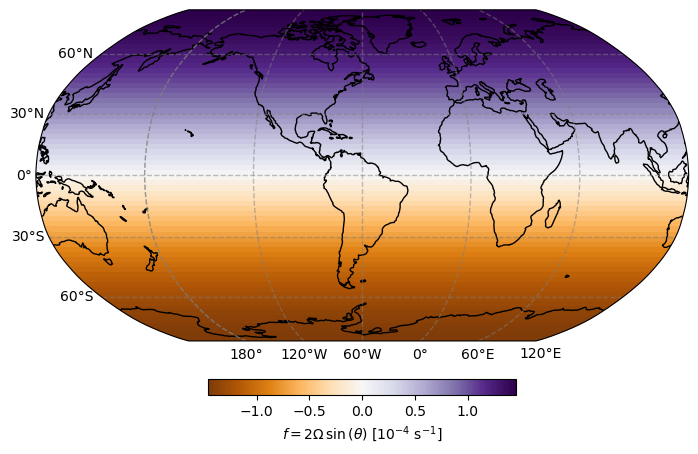

In [234]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = -60))
# ax.stock_img()
ax.coastlines()

C = (f * 1e4).plot(x = "longitude", y = "latitude", ax = ax, transform = ccrs.PlateCarree(), add_colorbar = False, cmap = "PuOr")
fig.colorbar(C, ax = ax, pad = 0.1, fraction = 0.04, label = "$f = 2\Omega\,\sin{(\\theta)}$ [10$^{-4}$ s$^{-1}$]", orientation = "horizontal")

ax.set_global()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

fig.savefig("../img/coriolis.png", dpi = 300, bbox_inches = "tight")

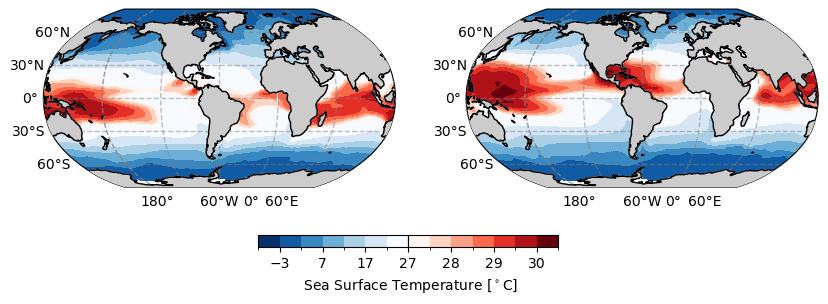

In [167]:
dT = 5

fig = plt.figure(figsize=(10, 3))
ax = [
    fig.add_subplot(1, 2, 1, projection = ccrs.Robinson(central_longitude = -60)),
    fig.add_subplot(1, 2, 2, projection = ccrs.Robinson(central_longitude = -60)),
]

cax = [
    fig.add_axes([0.34, 0, 0.15, 0.04]),
    fig.add_axes([0.49, 0, 0.15, 0.04])
]

kw = dict(x = "longitude", extend = "neither", transform = ccrs.PlateCarree(), add_colorbar = False)
for a, month in zip(ax, [2, 9]):
    c1 = (clim.sst.sel(month = month)-273).plot.contourf(ax = a, cmap = "Blues_r", vmin = -10, vmax = 27, levels = np.arange(-8, 27 + 5, 5), **kw)
    c2 = (clim.sst.sel(month = month)-273).plot.contourf(ax = a, cmap = "Reds", vmin = 27, vmax = 31, levels = np.arange(27, 31, 0.5), **kw)

    gl = a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

    a.set(title = "")

    a.add_feature(cfeature.LAND, zorder = 10, color = "0.8")
    a.coastlines(zorder = 11)

cbar = fig.colorbar(c1, cax = cax[0], orientation = "horizontal")
cbar.set_ticks([-3, 7, 17])
cbar.set_label(35*" " + "Sea Surface Temperature [$^\circ$C]")
cbar = fig.colorbar(c2, cax = cax[1], orientation = "horizontal")
cbar.set_ticks([27, 28, 29, 30])


fig.savefig("../img/SST.png", dpi = 300, bbox_inches = "tight")